# COMP 5214 and ELEC 5680
## Assignment 1 | Yin, Tianci (20587470)
---
In this problem, we will implement a model to classify digits using the MNIST
dataset. The dataset is available at https://git-disl.github.io/GTDLBench/
datasets/mnist_datasets/ or https://pytorch.org/vision/stable/generated/
torchvision.datasets.MNIST.html. Please use both training and test sets.
You can train your model for 20 epochs. Use a batch size of 64 to train the
model. Please submit a report and code for this assignment. You can use
Pytorch or Tensorflow in this assignment.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# quality of life
from tqdm import tqdm

In [2]:
# setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# predefined hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 64

> The use of `torch.utils.data.Subset` is only for prototyping; The final results are obtained by training on the entire dataset

In [4]:
from torch.utils.data import Subset

data_proportion = 1

train_dataset = datasets.MNIST(root='./_data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./_data', train=False, transform=transforms.ToTensor(), download=True)

# train_subset = Subset(train_dataset, np.random.choice(len(train_dataset), int(len(train_dataset) * data_proportion), replace=False))
# test_subset = Subset(test_dataset, np.random.choice(len(test_dataset), int(len(test_dataset) * data_proportion), replace=False))
# train_loader = DataLoader(dataset=train_subset, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(dataset=test_subset, batch_size=BATCH_SIZE, shuffle=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

As we will be testing out different neural network architectures, we can define a universal model training and evaluation pipeline.

In [5]:
def train_model(model, train_loader, test_loader, num_epochs=NUM_EPOCHS):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # training loop
    train_losses = []
    accuracies = []
    
    total_iters = len(train_loader) * num_epochs
    completed_iters = 0
    train_progress = tqdm(total=total_iters, leave=True, position=0)
    train_progress.set_description(f"Training")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            
            # forward
            pred = model(x)
            loss = criterion(pred, y)
            
            # backward
            loss.backward()
            optimizer.step()
            
            # stats
            running_loss += loss.item()
            completed_iters += 1
            
            train_progress.update(1)
            if (batch_idx % 100 == 0) or (batch_idx == len(train_loader)-1):
                train_progress.set_postfix(
                    epoch=f"{epoch+1}/{num_epochs}",
                    batch=f"{batch_idx+1}/{len(train_loader)}",
                    loss=f"{loss.item():.4f}"
                )

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # eval on test set
        epoch_acc = eval_model(model, test_loader)
        accuracies.append(epoch_acc)
        
        train_progress.set_description(f"Epoch {epoch+1:02}/{num_epochs}, Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")
    
    train_progress.close()
    return train_losses, accuracies

def eval_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x) # shape: (batch_size, 10)
            _, predicted = torch.max(pred.data, axis=1) # idx == predicted class
            total += y.shape[0] # num samples predicted == batch_size
            correct += (predicted == y).sum().item()
        
    return correct / total

### Multilayer Perceptron (MLP) (25 points)
---
Treat each image as a 784d (28 × 28) vector. Train a multilayer perceptron
model to classify images. Use two hidden layers (not including the input layer
and the output layers). Each hidden layer is a fully connected layer followed by
ReLU (Rectified Linear Unit f (x) = max(0, x)). The final layer should output
10 numbers indicating the scores of the 10 classes. Try cross-entropy loss for the
classification1. We can experiment with different neurons in the hidden layers.

What is the accuracy of such a model? 

Plot a curve of accuracy versus the number of neurons: 4, 8, 16, 32, 64, 128, and 256. We assume both hidden layers have the same neurons.

In [6]:
class MLP(nn.Module):
    def __init__(self, hidden_size):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, hidden_size)        # hidden layer 1
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # hidden layer 2
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [7]:
NEURONS_CANDIDATES = [4, 8, 16, 32, 64, 128, 256]

MNIST | Train set: 60000 | Test set: 10000
Training MLP with 4 neurons


Epoch 20/20, Loss: 0.8192, Test Accuracy: 0.7624: 100%|██████████| 18760/18760 [01:48<00:00, 172.24it/s, batch=938/938, epoch=20/20, loss=0.8161]


Training MLP with 8 neurons


Epoch 20/20, Loss: 0.2447, Test Accuracy: 0.9252: 100%|██████████| 18760/18760 [01:48<00:00, 173.41it/s, batch=938/938, epoch=20/20, loss=0.4336]


Training MLP with 16 neurons


Epoch 20/20, Loss: 0.1048, Test Accuracy: 0.9574: 100%|██████████| 18760/18760 [01:50<00:00, 169.37it/s, batch=938/938, epoch=20/20, loss=0.1481]


Training MLP with 32 neurons


Epoch 20/20, Loss: 0.0419, Test Accuracy: 0.9647: 100%|██████████| 18760/18760 [01:51<00:00, 167.81it/s, batch=938/938, epoch=20/20, loss=0.0467]


Training MLP with 64 neurons


Epoch 20/20, Loss: 0.0129, Test Accuracy: 0.9750: 100%|██████████| 18760/18760 [02:02<00:00, 152.58it/s, batch=938/938, epoch=20/20, loss=0.0023]


Training MLP with 128 neurons


Epoch 20/20, Loss: 0.0102, Test Accuracy: 0.9805: 100%|██████████| 18760/18760 [02:10<00:00, 143.75it/s, batch=938/938, epoch=20/20, loss=0.0081]


Training MLP with 256 neurons


Epoch 20/20, Loss: 0.0083, Test Accuracy: 0.9757: 100%|██████████| 18760/18760 [02:15<00:00, 138.13it/s, batch=938/938, epoch=20/20, loss=0.0085]


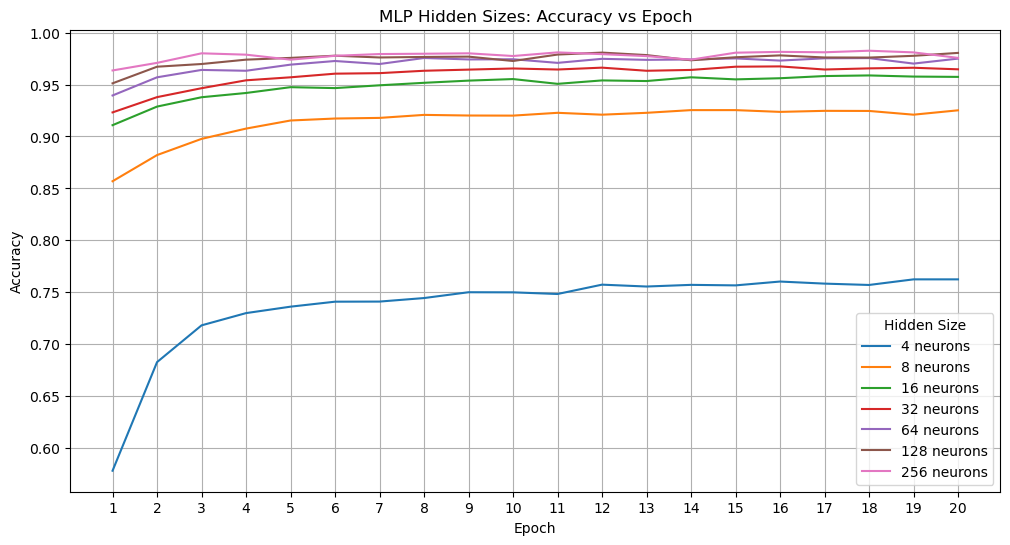

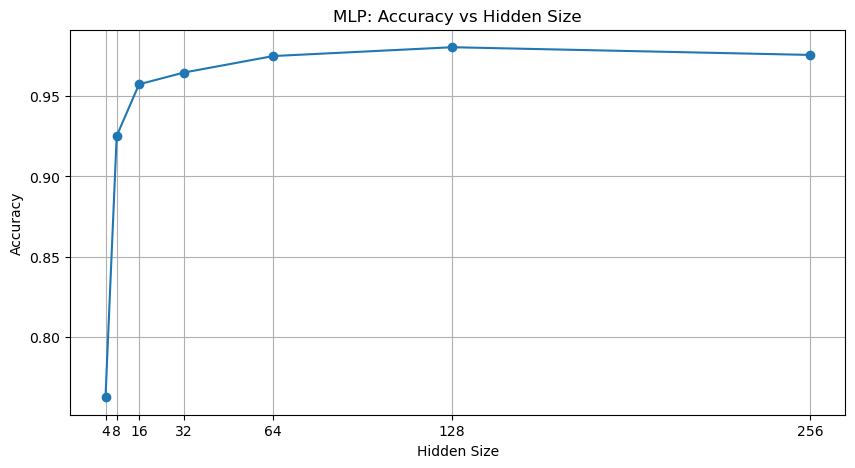

In [8]:
print(f"MNIST | Train set: {len(train_loader.dataset)} | Test set: {len(test_loader.dataset)}")

final_accs = []

plt.figure(figsize=(12, 6))
plt.title("MLP Hidden Sizes: Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1,NUM_EPOCHS+1))
plt.grid(True)

for hidden_size in NEURONS_CANDIDATES:
    print("="*150)
    print(f"Training MLP with {hidden_size} neurons")
    model = MLP(hidden_size).to(device)
    losses, accuracies = train_model(model, train_loader, test_loader)
    final_accs.append(accuracies[-1])
    plt.plot(range(1,NUM_EPOCHS+1), accuracies, label=f"{hidden_size} neurons")

plt.legend(title="Hidden Size")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(NEURONS_CANDIDATES, final_accs, marker='o')
plt.title("MLP: Accuracy vs Hidden Size")
plt.xlabel("Hidden Size")
plt.ylabel("Accuracy")
plt.grid()
plt.xticks(NEURONS_CANDIDATES)
plt.show()
    

### Convolutional Neural Networks (CNN) (25 points)
---
Implement the LeNet-5 convolutional neural network. You can follow this tutorial for the details of the [LeNet](https://pub.towardsai.net/the-architecture-implementation-of-lenet-5-eef03a68d1f7).

Please use input image size 28 × 28 in your model, although the input image
size in the original LeNet-5 model is 32 × 32. 

What is the accuracy of the
LeNet-5 model?

In [9]:
class LeNet5_tuto(nn.Module):
    def __init__(self):
        super(LeNet5_tuto, self).__init__()
        # model according to the tutorial: with 24x24 c1 output
        # C1: 6 filters of 5x5 (28x28x1 -> 24x24x6)
        self.c1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.Tanh()
        )
        # S2: average pooling 2x2 (24x24x6 -> 12x12x6)
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)
        # C3: 16 filters of 5x5 (12x12x6 -> 8x8x16)
        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.Tanh()
        )
        # S4: average pooling 2x2 (8x8x16 -> 4x4x16)
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)
        # Flatten (4x4x16 -> 256)
        self.flatten = nn.Flatten()
        # F5: Fully connected (256 -> 120)
        self.f5 = nn.Sequential(
            nn.Linear(256, 120),
            nn.Tanh()
        )
        # F6: Fully connected (120 -> 84)
        self.f6 = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh()
        )
        # F7: Fully connected (84 -> 10)
        self.output = nn.Linear(84, 10)
        # softmax is not needed as we use CrossEntropyLoss
        
    def forward(self, x):
        x = self.c1(x)
        x = self.s2(x)
        x = self.c3(x)
        x = self.s4(x)
        x = self.flatten(x)
        x = self.f5(x)
        x = self.f6(x)
        x = self.output(x)
        return x

Just out of curiosity, since the tutorial takes image inputs with dimensions of 28x28 as is and therefore has to ommit c5, I want to test, whether there is any performance disparity if I were to add zero padding to c1, to preserve a c1 output size of (28x28x6) as in the original implementation:

In [10]:
class LeNet5_mod(nn.Module):
    def __init__(self):
        super(LeNet5_mod, self).__init__()
        # model with 28x28 c1 output
        # C1: 6 filters of 5x5 (28x28x1 -> 28x28x6)
        self.c1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        )
        # S2: average pooling 2x2 (28x28x6 -> 14x14x6)
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)
        # C3: 16 filters of 5x5 (14x14x6 -> 10x10x16)
        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.Tanh()
        )
        # S4: average pooling 2x2 (10x10x16 -> 5x5x16)
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)
        # C5: 120 filters of 5x5 (5x5x16 -> 1x1x120)
        self.c5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0),
            nn.Tanh()
        )
        self.flatten = nn.Flatten()
        # F6: Fully connected (120 -> 84)
        self.f6 = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh()
        )
        # F7: Fully connected (84 -> 10)
        self.output = nn.Linear(84, 10)
        # softmax is not needed as we use CrossEntropyLoss
        
    def forward(self, x):
        x = self.c1(x)
        x = self.s2(x)
        x = self.c3(x)
        x = self.s4(x)
        x = self.c5(x)
        x = self.flatten(x)
        x = self.f6(x)
        x = self.output(x)
        return x

In [11]:
from torchsummary import summary

print("LeNet5_tuto")
model = LeNet5_tuto().to(device)
summary(model, (1, 28, 28))

print("\nLeNet5 with padding 2")
model = LeNet5_mod().to(device)
summary(model, (1, 28, 28))

LeNet5_tuto
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
              Tanh-2            [-1, 6, 24, 24]               0
         AvgPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
              Tanh-5             [-1, 16, 8, 8]               0
         AvgPool2d-6             [-1, 16, 4, 4]               0
           Flatten-7                  [-1, 256]               0
            Linear-8                  [-1, 120]          30,840
              Tanh-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             Tanh-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
---------------------

MNIST | Train set: 60000 | Test set: 10000
Training LeNet according to the tutorial


Epoch 20/20, Loss: 0.0064, Test Accuracy: 0.9872: 100%|██████████| 18760/18760 [02:06<00:00, 148.20it/s, batch=938/938, epoch=20/20, loss=0.0121]


Training LeNet with C1 padding 2


Epoch 20/20, Loss: 0.0068, Test Accuracy: 0.9870: 100%|██████████| 18760/18760 [02:15<00:00, 138.00it/s, batch=938/938, epoch=20/20, loss=0.0002]


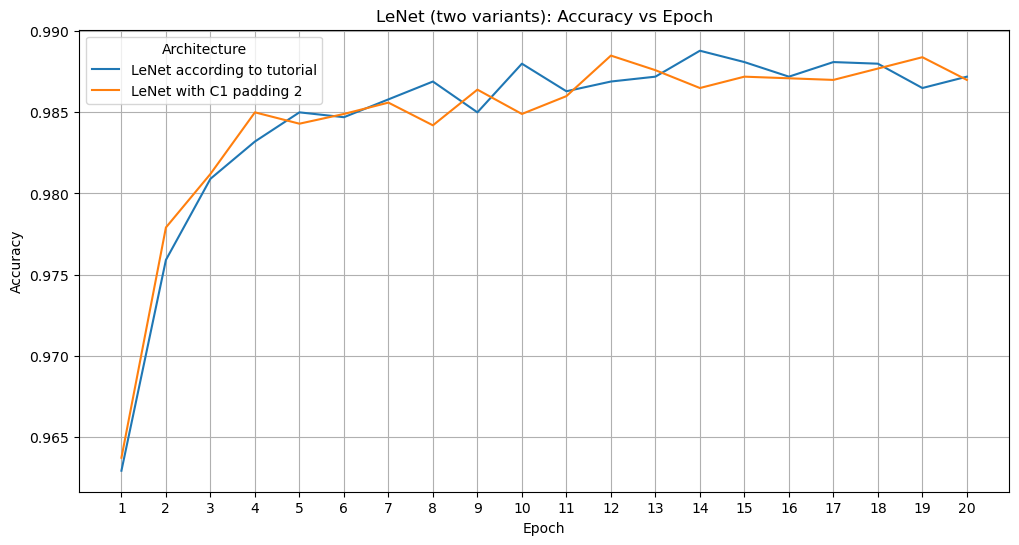

In [12]:
print(f"MNIST | Train set: {len(train_loader.dataset)} | Test set: {len(test_loader.dataset)}")

plt.figure(figsize=(12, 6))
plt.title("LeNet (two variants): Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1,NUM_EPOCHS+1))
plt.grid(True)

print("="*150)
print("Training LeNet according to the tutorial")
model = LeNet5_tuto().to(device)
losses, accuracies = train_model(model, train_loader, test_loader)
plt.plot(range(1,NUM_EPOCHS+1), accuracies, label=f"LeNet according to tutorial")

print("="*150)
print("Training LeNet with C1 padding 2")
model = LeNet5_mod().to(device)
losses, accuracies = train_model(model, train_loader, test_loader)
plt.plot(range(1,NUM_EPOCHS+1), accuracies, label=f"LeNet with C1 padding 2")

plt.legend(title="Architecture")
plt.show()

### Context Aggregation Networks (CAN) (25 points)
---
We can also implement a simple CNN model with dilated convolutions. We can
have a model with a large receptive field with the same spatial resolution in the
hidden layers. See the network architecture in the Table 1. For your information,
the dilated residual network2 is a similar model for image classification.

| Operation       | 3 × 3 conv | 3 × 3 conv | 3 × 3 conv | 3 × 3 conv | 3 × 3 conv | Avg pool |
|-----------------|------------|------------|------------|------------|------------|----------|
| Activation      | LReLU      | LReLU      | LReLU      | LReLU      | LReLU      | N/A      |
| Dilation        | 1          | 2          | 4          | 8          | 1          | N/A      |
| Receptive field | 3 × 3      | 7 × 7      | 15 × 15    | 31 × 31    | 33 × 33    | N/A      |
| Feature channels| 32         | 32         | 32         | 32         | 10         | 10       |

What is the accuracy of such a CAN model? 

What will be the accuracy if
we use a different number of feature channels instead of 32?

In [13]:
class CANet(nn.Module):
    def __init__(self, feature_channels=32):
        super(CANet, self).__init__()
        self.c1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=feature_channels, kernel_size=3, dilation=1, padding=1),
            nn.LeakyReLU()
        )
        self.c2 = nn.Sequential(
            nn.Conv2d(in_channels=feature_channels, out_channels=feature_channels, kernel_size=3, dilation=2, padding=2),
            nn.LeakyReLU()
        )
        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=feature_channels, out_channels=feature_channels, kernel_size=3, dilation=4, padding=4),
            nn.LeakyReLU()
        )
        self.c4 = nn.Sequential(
            nn.Conv2d(in_channels=feature_channels, out_channels=feature_channels, kernel_size=3, dilation=8, padding=8),
            nn.LeakyReLU()
        )
        self.c5 = nn.Sequential(
            nn.Conv2d(in_channels=feature_channels, out_channels=10, kernel_size=3, dilation=1, padding=1),
            nn.LeakyReLU()
        )
        self.s6 = nn.AdaptiveAvgPool2d(1) # shape: (batch_size, 10, 1, 1)
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.c3(x)
        x = self.c4(x)
        x = self.c5(x)
        x = self.s6(x)
        x = self.flatten(x)
        return x

In [14]:
model = CANet(feature_channels=32).to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         LeakyReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           9,248
         LeakyReLU-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]           9,248
         LeakyReLU-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 32, 28, 28]           9,248
         LeakyReLU-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]           2,890
        LeakyReLU-10           [-1, 10, 28, 28]               0
AdaptiveAvgPool2d-11             [-1, 10, 1, 1]               0
          Flatten-12                   [-1, 10]               0
Total params: 30,954
Trainable params: 30,954
Non-trainable params: 0
---------------------------------

In [15]:
FEATURE_CHANNEL_CANDIDATES = [4, 8, 16, 32, 64, 128, 256]

MNIST | Train set: 60000 | Test set: 10000
Training CANet with 4 feature channels


Epoch 20/20, Loss: 0.3706, Test Accuracy: 0.9112: 100%|██████████| 18760/18760 [02:01<00:00, 153.88it/s, batch=938/938, epoch=20/20, loss=0.5821]


Training CANet with 8 feature channels


Epoch 20/20, Loss: 0.0897, Test Accuracy: 0.9757: 100%|██████████| 18760/18760 [02:05<00:00, 149.36it/s, batch=938/938, epoch=20/20, loss=0.0794]


Training CANet with 16 feature channels


Epoch 20/20, Loss: 0.0399, Test Accuracy: 0.9878: 100%|██████████| 18760/18760 [01:57<00:00, 159.67it/s, batch=938/938, epoch=20/20, loss=0.0003]


Training CANet with 32 feature channels


Epoch 20/20, Loss: 0.0146, Test Accuracy: 0.9866: 100%|██████████| 18760/18760 [02:44<00:00, 114.00it/s, batch=938/938, epoch=20/20, loss=0.0041]


Training CANet with 64 feature channels


Epoch 20/20, Loss: 0.0083, Test Accuracy: 0.9920: 100%|██████████| 18760/18760 [04:23<00:00, 71.31it/s, batch=938/938, epoch=20/20, loss=0.0001]


Training CANet with 128 feature channels


Epoch 20/20, Loss: 0.0039, Test Accuracy: 0.9945: 100%|██████████| 18760/18760 [09:34<00:00, 32.68it/s, batch=938/938, epoch=20/20, loss=0.0000]


Training CANet with 256 feature channels


Epoch 20/20, Loss: 0.0036, Test Accuracy: 0.9914: 100%|██████████| 18760/18760 [27:36<00:00, 11.33it/s, batch=938/938, epoch=20/20, loss=0.0024]


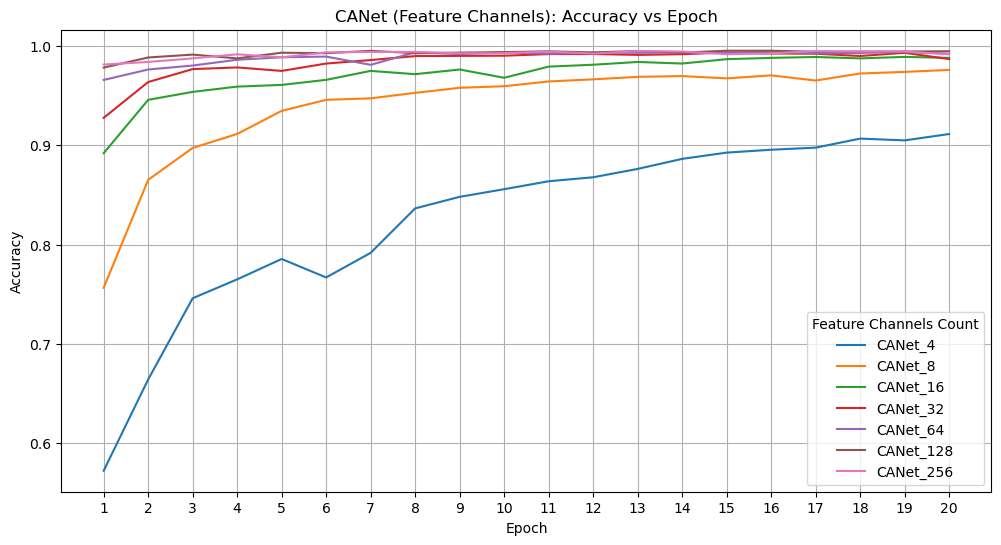

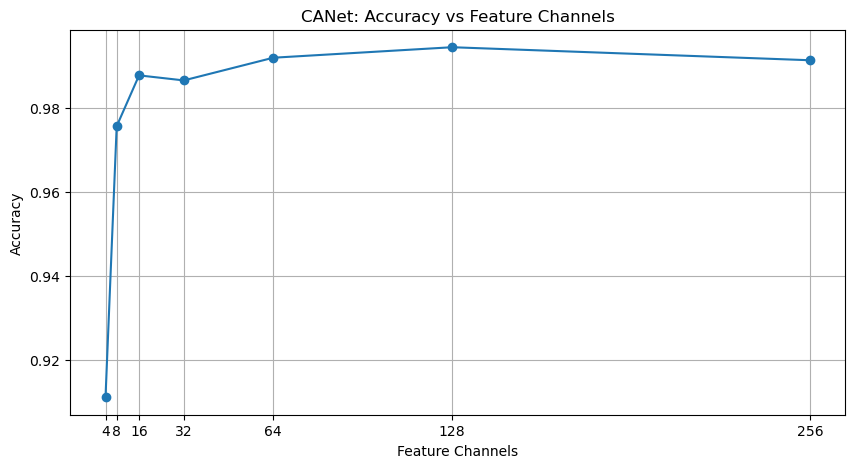

In [16]:
print(f"MNIST | Train set: {len(train_loader.dataset)} | Test set: {len(test_loader.dataset)}")

total_accs = []

plt.figure(figsize=(12, 6))
plt.title("CANet (Feature Channels): Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1,NUM_EPOCHS+1))
plt.grid(True)

for feature_channels in FEATURE_CHANNEL_CANDIDATES:
    print("="*150)
    print(f"Training CANet with {feature_channels} feature channels")
    model = CANet(feature_channels=feature_channels).to(device)
    losses, accuracies = train_model(model, train_loader, test_loader)
    total_accs.append(accuracies[-1])
    plt.plot(range(1,NUM_EPOCHS+1), accuracies, label=f"CANet_{feature_channels}")

plt.legend(title="Feature Channels Count")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(FEATURE_CHANNEL_CANDIDATES, total_accs, marker='o')
plt.title("CANet: Accuracy vs Feature Channels")
plt.xlabel("Feature Channels")
plt.ylabel("Accuracy")
plt.grid()
plt.xticks(FEATURE_CHANNEL_CANDIDATES)
plt.show()